# IEEE-CIS Fraud Detection — 02 Feature Engineering, Modeling & Evaluation

This notebook implements the modeling pipeline for the real IEEE-CIS competition dataset, including:

1. **Feature engineering** — selection, missing value handling, encoding, normalization
2. **Baseline models** — Logistic Regression, Random Forest, LightGBM, XGBoost, CatBoost
3. **PyTorch Neural Net** — tuned architecture, early stopping, GPU support
4. **Evaluation** — ROC-AUC, PR-AUC, Brier, ECE, SHAP, threshold optimization, hard-sample analysis
5. **Serialization** — save model, features, and threshold for production use

> Run each cell and update comments/conclusions after seeing real results.

## 1 — Import Required Libraries

Import all standard, machine learning, and visualization libraries used in the pipeline.

In [11]:
import os, glob, warnings, gc
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import kagglehub
from borutashap import BorutaShap
import joblib

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_columns', 50)

print('Imports OK — Torch:', torch.__version__, '| CUDA:', torch.cuda.is_available())

ModuleNotFoundError: No module named 'borutashap'

## 2 — Get the data, execute a MICE imputation with a strong model (xgboost) and create null columns mask to featurize the missing values

In [ ]:
from pathlib import Path

cwd = Path.cwd()
print(f'Working directory: {cwd}')

# Kaggle login cell — run this once before running the data-loading cell below
kagglehub.login()
print('kagglehub login attempted — if this raised, re-run after configuring credentials.')


Working directory: c:\Users\rvito\code\personal\public_projects\Fraud Detection\notebooks


kagglehub login attempted — if this raised, re-run after configuring credentials.


In [3]:
# Simple load_data() that assumes kagglehub is available and configured
def load_data():
    print('Downloading competition files via kagglehub...')
    data_dir = Path(kagglehub.competition_download('ieee-fraud-detection'))
    tx = data_dir / 'train_transaction.csv'
    idp = data_dir / 'train_identity.csv'
    if not (tx.exists() and idp.exists()):
        raise RuntimeError(f'Expected files not found under {data_dir}.\nPlease ensure kagglehub downloaded the files or download them manually.')
    train_txn = pd.read_csv(tx)
    train_id = pd.read_csv(idp)
    return train_txn, train_id

# Execute load (this will raise a clear error if kagglehub isn't configured or files missing)
train_txn, train_id = load_data()
print(f'Loaded transactions: {len(train_txn):,}, identities: {len(train_id):,}')

# Merge
full = train_txn.merge(train_id, on='TransactionID', how='left')
del train_txn, train_id
gc.collect()
print(f'Merged dataframe: {full.shape[0]:,} rows x {full.shape[1]} columns')

Loaded transactions: 590,540, identities: 144,233
Merged dataframe: 590,540 rows x 434 columns


In [ ]:
# Feature selection (remove IDs and obvious columns)
ignore_cols = ['TransactionID', 'TransactionDT']
if 'isFraud' in full.columns:
    X = full.drop(columns=[c for c in ignore_cols if c in full.columns] + ['isFraud'])
    y = full['isFraud'].astype(int)
else:
    X = full.drop(columns=[c for c in ignore_cols if c in full.columns])
    y = pd.Series([0]*len(full))

# Categorical encoding (LabelEncoder for simplicity) - save encoders for reuse
cat_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in cat_cols:
    X[col] = X[col].fillna('missing').astype(str)
    le = LabelEncoder().fit(X[col])
    X[col] = le.transform(X[col])
    label_encoders[col] = le

# Ensure a random seed is defined for reproducibility (used by imputer below)
SEED = globals().get('SEED', 42)

# Fill numeric missing values with a memory-friendly strategy:
# 1) add _null indicators, 2) downcast numeric dtypes, 3) try a sampled XGBRegressor with reduced feature set,
#    and 4) fallback to median if memory or training fails.
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# First, create missing indicators for all numeric columns
for c in num_cols:
    X[c + '_null'] = X[c].isna().astype(np.int8)
# Downcast numeric columns to reduce memory (float32 / int32 where safe)
for c in num_cols:
    try:
        if pd.api.types.is_float_dtype(X[c].dtype):
            X[c] = X[c].astype(np.float32)
        elif pd.api.types.is_integer_dtype(X[c].dtype):
            X[c] = X[c].fillna(0).astype(np.int32)
            # keep NaNs handled separately via _null indicator
    except Exception:
        pass

# Now impute each numeric column's missing values using a low-memory procedure
from sklearn.model_selection import train_test_split
MAX_TRAIN_ROWS = 100000  # limit rows used to train per-column imputer to reduce memory
MAX_FEAT = 60  # limit number of features used for imputation
import sys

# helper for improved progress: compare imputed vs remaining
def _progress_msg(imputed, total):
    remaining = max(0, total - imputed)
    # show counts only (no percent) and pad the line to avoid leftover characters
    return f'Imputed {imputed}/{total} | Remaining: {remaining}    \r'

# Build list of columns that require imputation
cols_to_impute = [c for c in num_cols if X[c].isna().any()]
total_impute = len(cols_to_impute)
imputed = 0
for c in cols_to_impute:
    miss_mask = X[c].isna()
    miss_count = int(miss_mask.sum())
    if miss_count == 0:
        imputed += 1
        sys.stdout.write(_progress_msg(imputed, total_impute))
        sys.stdout.flush()
        continue
    miss_frac = miss_count / len(X)
    # dynamic inline status (show count only; percent removed per user request)
    sys.stdout.write(f'Imputing {imputed+1}/{total_impute}: {c} (missing={miss_count})\r')
    sys.stdout.flush()
    # Candidate feature columns: exclude target column and its null indicator
    feat_cols = [col for col in X.columns if col != c and col != (c + '_null')]
    # Remove columns that are entirely null or non-numeric to keep memory low
    feat_cols = [col for col in feat_cols if (not X[col].isna().all()) and pd.api.types.is_numeric_dtype(X[col].dtype)]
    if len(feat_cols) == 0:
        X.loc[miss_mask, c] = X.loc[~miss_mask, c].median()
        imputed += 1
        sys.stdout.write(_progress_msg(imputed, total_impute))
        sys.stdout.flush()
        continue
    # Optionally reduce features by correlation with the target column (computed on non-missing rows)
    try:
        corr = X.loc[~miss_mask, feat_cols].corrwith(X.loc[~miss_mask, c].astype('float32')).abs().sort_values(ascending=False)
        top_feats = corr.head(MAX_FEAT).index.tolist()
        if len(top_feats) > 0:
            feat_cols = top_feats
    except Exception:
        feat_cols = feat_cols[:MAX_FEAT]
    # Train on rows where c is present (limit rows to MAX_TRAIN_ROWS)
    train_idx = X.index[~miss_mask].to_list()
    if len(train_idx) > MAX_TRAIN_ROWS:
        rng = np.random.RandomState(SEED)
        train_idx = list(rng.choice(train_idx, size=MAX_TRAIN_ROWS, replace=False))
    # Prepare training arrays with safe dtype and fill remaining NaNs with a sentinel
    X_train_feats = X.loc[train_idx, feat_cols].astype(np.float32).fillna(-999.0)
    y_train_vals = X.loc[train_idx, c].astype(np.float32).fillna(X.loc[~miss_mask, c].median())
    # If training set is tiny, fallback to median
    if len(y_train_vals) < 50:
        X.loc[miss_mask, c] = X.loc[~miss_mask, c].median()
        imputed += 1
        sys.stdout.write(_progress_msg(imputed, total_impute))
        sys.stdout.flush()
        continue
    try:
        # Use a modest XGBRegressor; limit resources and verbosity
        xgb_imp = XGBRegressor(tree_method='hist', n_estimators=100, learning_rate=0.05, max_depth=6, random_state=SEED, verbosity=0, n_jobs=1)
        xgb_imp.fit(X_train_feats, y_train_vals)
        # Prepare predict matrix (also downcast/fill)
        X_pred_feats = X.loc[miss_mask, feat_cols].astype(np.float32).fillna(-999.0)
        # Predict in batches if needed to avoid a single large allocation
        BATCH = 50000
        preds = []
        if len(X_pred_feats) == 0:
            raise ValueError('No rows to predict')
        for start in range(0, len(X_pred_feats), BATCH):
            end = start + BATCH
            batch_pred = xgb_imp.predict(X_pred_feats.iloc[start:end])
            preds.append(batch_pred.astype(np.float32))
        preds = np.concatenate(preds)
        X.loc[miss_mask, c] = preds
    except Exception as e:
        sys.stdout.write(f'Imputation failed for {c}, fallback to median ({imputed+1}/{total_impute})\n')
        sys.stdout.flush()
        X.loc[miss_mask, c] = X.loc[~miss_mask, c].median()
    # free memory
    try:
        del X_train_feats, X_pred_feats, y_train_vals, preds, xgb_imp
    except Exception:
        pass
    import gc; gc.collect()
    imputed += 1
    # update final progress for this column
    sys.stdout.write(_progress_msg(imputed, total_impute))
    sys.stdout.flush()

# finish progress line
if total_impute > 0:
    sys.stdout.write('\n')
    sys.stdout.flush()

In [ ]:
# --- Feature selection using BorutaShap (required)
print('Running BorutaShap feature selection (this may take a while)...')
# Prepare data for BorutaShap: no NaNs
X_sel = X.copy()
if X_sel.isna().any().any():
    X_sel = X_sel.fillna(0)

# Try to construct an XGBoost classifier for BorutaShap; fall back to string spec
try:
    model_for_boruta = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
except Exception:
    model_for_boruta = None

# Run BorutaShap with safe fallbacks
BORUTA_TRIALS = 50
try:
    if model_for_boruta is not None:
        boruta = BorutaShap(model=model_for_boruta, importance_measure='shap', classification=True)
        boruta.fit(X_sel, y.values, n_trials=BORUTA_TRIALS, train_or_test='test')
    else:
        boruta = BorutaShap(model='xgboost', importance_measure='shap', classification=True)
        boruta.fit(X_sel, y.values, n_trials=BORUTA_TRIALS, train_or_test='test')
except Exception:
    # try a simpler call signature
    try:
        boruta = BorutaShap(model='xgboost', importance_measure='shap', classification=True)
        boruta.fit(X_sel, y.values, n_trials=BORUTA_TRIALS)
    except Exception as e:
        raise RuntimeError(f'BorutaShap run failed: {e}') from e

# Extract selected features from common attributes
selected_features = None
for attr in ('accepted_features', 'selected_features', 'features', 'features_selected', 'support_', 'support'):
    val = getattr(boruta, attr, None)
    if val is not None and len(val) > 0:
        try:
            selected_features = list(val)
        except Exception:
            selected_features = [str(v) for v in val]
        break

# Some versions expose results_ DataFrame with 'decision' column
if not selected_features:
    res = getattr(boruta, 'results_', None) or getattr(boruta, 'results', None)
    if res is not None and hasattr(res, 'loc'):
        if 'decision' in res.columns:
            selected_features = res[res['decision'] == 'Accepted'].index.astype(str).tolist()

if not selected_features:
    raise RuntimeError('BorutaShap did not return selected features; aborting.')

# Subset X to selected features
X = X[selected_features]
if 'artefacts' not in globals(): artefacts = {}
artefacts['borutashap_selected'] = selected_features
print(f'BorutaShap selected {len(selected_features)} features')

# Save encoders into artefacts for later use in submission/inference
if 'artefacts' not in globals(): artefacts = {}
artefacts['label_encoders'] = label_encoders

print(f'Final shape: {X.shape}')

## 3 — Train, Validation, and Test Split

Split the data into train, validation, and test sets (e.g., 60/20/20), stratifying by fraud to maintain class balance.

In [ ]:
# Time-based 60/20/20 split using TransactionDT (prevents temporal leakage)
# Sort the original dataframe by TransactionDT to preserve temporal order
full_sorted = full.sort_values('TransactionDT')
n = len(full_sorted)
i_train = int(n * 0.6)
i_val   = int(n * 0.8)

train_idx = full_sorted.index[:i_train]
val_idx   = full_sorted.index[i_train:i_val]
test_idx  = full_sorted.index[i_val:]

# Use the indices to slice the already-prepared feature matrix `X` and target `y`
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

print(f'Time-based split — Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}')
print(f'Fraud rate (train): {y_train.mean():.4%} | (val): {y_val.mean():.4%} | (test): {y_test.mean():.4%}')

Train: 354,324 | Val: 118,108 | Test: 118,108
Fraud rate (train): 3.4991% | (val): 3.4993% | (test): 3.4985%


## 4 — Baseline Models: LR, RF, LightGBM, XGBoost

Train and evaluate five classic models for initial comparison. Use ROC-AUC, PR-AUC, Brier, and ECE as metrics.

Processing: Logistic Regression
Logistic Regression — AUC=0.8440 AP=0.2967 LogLoss=0.471804 Brier=0.147167 ECE=0.2965

Processing: Random Forest
 Using subsample of 70,864 rows for CV (original: 354,324)
 Running RandomizedSearchCV for Random Forest (cv=3)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
  Best params: {'n_estimators': 500, 'min_samples_split': 8, 'max_features': 'sqrt', 'max_depth': None}
Random Forest — AUC=0.9360 AP=0.6941 LogLoss=0.087735 Brier=0.018589 ECE=0.0262

Processing: LightGBM
 Using subsample of 70,864 rows for CV (original: 354,324)
 Running RandomizedSearchCV for LightGBM (cv=3)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
  Best params: {'subsample': 0.6, 'num_leaves': 127, 'n_estimators': 400, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
LightGBM — AUC=0.9385 AP=0.7059 LogLoss=0.072925 Brier=0.017389 ECE=0.0098

Processing: XGBoost
 Using subsample of 70,864 rows for CV (original: 354,324)
 Running RandomizedSearchCV

,ROC-AUC,PR-AUC,Brier,ECE,LogLoss
XGBoost,0.9435,0.7279,0.0163,0.0074,0.0684
LightGBM,0.9385,0.7059,0.0174,0.0098,0.0729
Random Forest,0.9360,0.6941,0.0186,0.0262,0.0877
Logistic Regression,0.8440,0.2967,0.1472,0.2965,0.4718


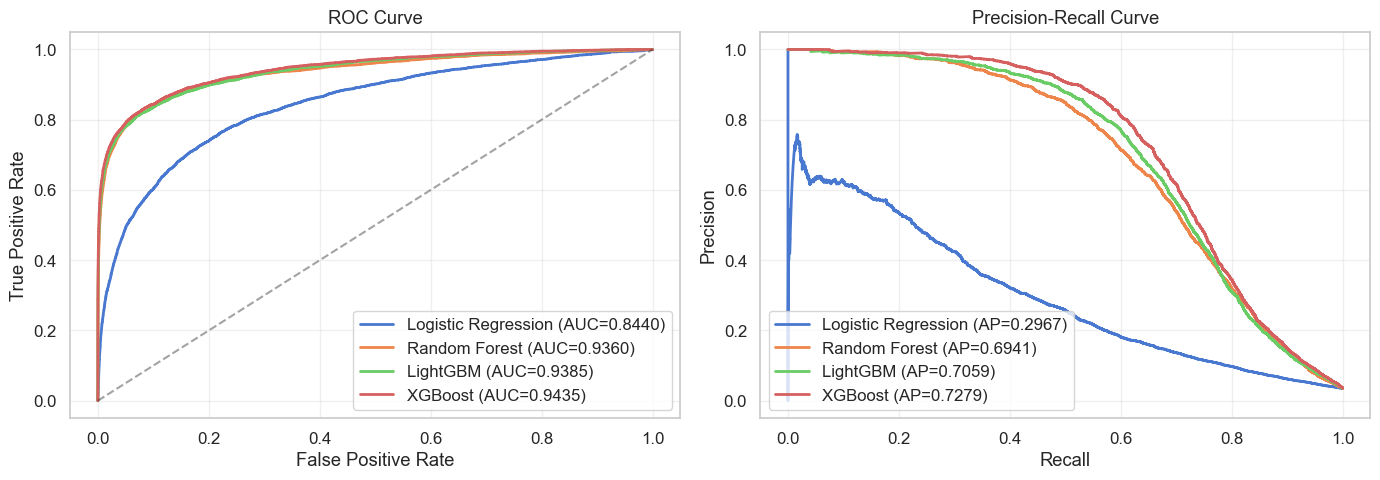

In [ ]:
from ds_tools.evaluation.calibration import brier_score, expected_calibration_error
from ds_tools.visualization.plots import plot_roc_pr
from sklearn.metrics import make_scorer
from scipy.stats import ks_2samp

SEED = 42
cv = TimeSeriesSplit(n_splits=3)  # time-series CV (no shuffling)

# Models and (optional) hyperparameter distributions for randomized search
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEED)),
    ]),
    'Random Forest': RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=SEED),
    'LightGBM': LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=63, random_state=SEED, n_jobs=-1, verbose=-1),
    'XGBoost': XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=SEED, verbosity=0, n_jobs=-1),
}

# Focused, production-quality search spaces (smaller but more informative)
param_dists = {
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [8, 12, 20, None],
        'min_samples_split': [2, 4, 8],
        'max_features': ['sqrt', 'log2']
    },
    'LightGBM': {
        'n_estimators': [100, 200, 400],
        'num_leaves': [31, 63, 127],
        'learning_rate': [0.01, 0.03, 0.05],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 400],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.03, 0.05],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.5]
    }
}

results = {}
y_prob_dict = {}

# Use negative log-loss as scorer for search
for name, estimator in models.items():
    print(f"Processing: {name}")
    if name in param_dists:
        # Subsample for hyperparameter tuning to avoid memory issues (20% of data)
        sample_frac = 0.2
        X_train_sample, _, y_train_sample, _ = train_test_split(
            X_train, y_train, train_size=sample_frac, stratify=y_train, random_state=SEED
        )
        print(f" Using subsample of {len(X_train_sample):,} rows for CV (original: {len(X_train):,})")
        print(f" Running RandomizedSearchCV for {name} (cv={cv.get_n_splits()})...")
        search = RandomizedSearchCV(
            estimator,
            param_distributions=param_dists[name],
            n_iter=6,
            scoring='neg_log_loss',
            cv=cv,
            random_state=SEED,
            n_jobs=3,
            verbose=1
        )
        search.fit(X_train_sample, y_train_sample)
        best = search.best_estimator_
        print(f"  Best params: {search.best_params_}")
        # Refit on full training data
        best.fit(X_train, y_train)
    else:
        best = estimator
        best.fit(X_train, y_train)

    # Predict on validation set
    if hasattr(best, 'predict_proba'):
        y_prob = best.predict_proba(X_val)[:,1]
    else:
        try:
            y_prob = best.predict_proba(X_val)[:,1]
        except Exception:
            logits = best.decision_function(X_val)
            y_prob = 1 / (1 + np.exp(-logits))

    y_prob_dict[name] = y_prob

    auc_val = roc_auc_score(y_val, y_prob)
    ap_val  = average_precision_score(y_val, y_prob)
    brier   = brier_score(y_val.values, y_prob)
    ece_val = expected_calibration_error(y_val.values, y_prob)
    logloss = log_loss(y_val, y_prob)
    try:
        ks_val = ks_2samp(y_prob[y_val==1], y_prob[y_val==0]).statistic
    except Exception:
        ks_val = float('nan')

    results[name] = {'ROC-AUC': auc_val, 'PR-AUC': ap_val, 'Brier': brier, 'ECE': ece_val, 'LogLoss': logloss, 'KS': ks_val}
    print(f"{name} — AUC={auc_val:.4f} AP={ap_val:.4f} LogLoss={logloss:.6f} Brier={brier:.6f} ECE={ece_val:.4f}\n")

results_df = pd.DataFrame(results).T.sort_values('PR-AUC', ascending=False)
display(results_df)

fig = plot_roc_pr(y_val.values, y_prob_dict)
plt.show()

## 5 — PyTorch Neural Net: Training and Evaluation

Implementation of a tuned feedforward neural network for tabular data, with early stopping, batch norm, dropout, and GPU support. Evaluation as for classic models.

CUDA available: True
Epoch 1: train_loss=1.17098, val_loss=1.07362, lr=0.000051
Epoch 2: train_loss=1.05570, val_loss=0.98965, lr=0.000082
Epoch 3: train_loss=0.99865, val_loss=0.95871, lr=0.000132
Epoch 4: train_loss=0.96351, val_loss=0.93649, lr=0.000199
Epoch 5: train_loss=0.94483, val_loss=0.91543, lr=0.000280
Epoch 6: train_loss=0.92624, val_loss=0.92257, lr=0.000372
Epoch 7: train_loss=0.92039, val_loss=0.92606, lr=0.000470
Epoch 8: train_loss=0.90684, val_loss=0.90395, lr=0.000571
Epoch 9: train_loss=0.90380, val_loss=0.89342, lr=0.000669
Epoch 10: train_loss=0.89606, val_loss=0.93968, lr=0.000761
Epoch 11: train_loss=0.88935, val_loss=0.89630, lr=0.000842
Epoch 12: train_loss=0.88435, val_loss=0.94142, lr=0.000909
Epoch 13: train_loss=0.88120, val_loss=0.91761, lr=0.000959
Epoch 14: train_loss=0.87617, val_loss=0.88175, lr=0.000990
Epoch 15: train_loss=0.86469, val_loss=0.89259, lr=0.001000
Epoch 16: train_loss=0.86313, val_loss=0.99526, lr=0.000998
Epoch 17: train_loss=0.85660

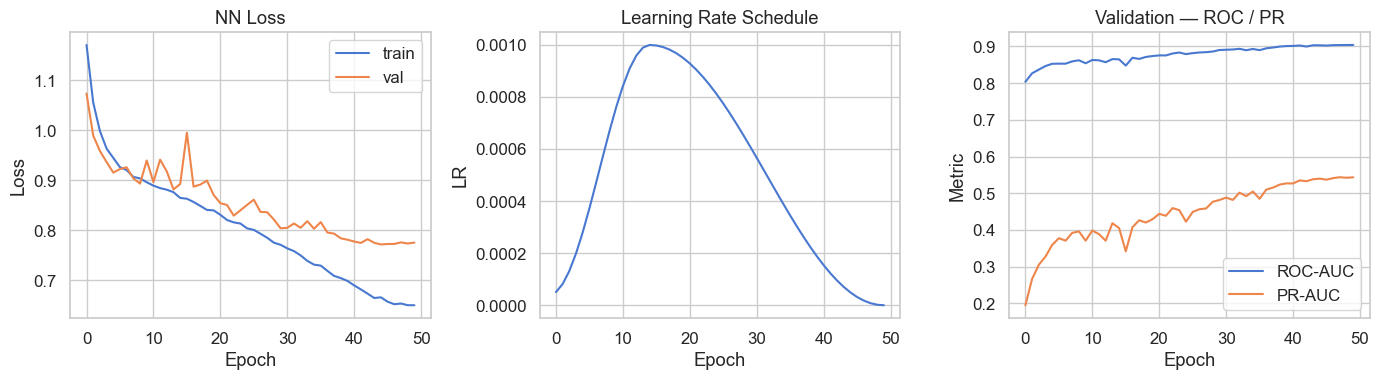

In [ ]:
class FraudDataset(Dataset):
    def __init__(self, X, y):
        # Expect numpy arrays or pandas DataFrame
        if isinstance(X, pd.DataFrame):
            X = X.values
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)
        self.bn = nn.BatchNorm1d(dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        residual = x
        out = self.linear(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        return out + residual

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        self.res_blocks = nn.Sequential(
            ResidualBlock(512),
            ResidualBlock(512),
            ResidualBlock(512)
        )
        self.output_layer = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)  # logits
        )

    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_blocks(x)
        return self.output_layer(x).squeeze(-1)

# We'll use Optuna + skorch to tune a neural net (skorch expects a module that outputs logits for each class).
# This cell constructs a skorch-compatible module and runs OptunaSearchCV.

# First, scale features (fit on train)
scaler_nn = StandardScaler()
X_train_scaled = pd.DataFrame(scaler_nn.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler_nn.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler_nn.transform(X_test), columns=X_test.columns, index=X_test.index)

# Try imports for tuning
try:
    import optuna
    from optuna.integration import OptunaSearchCV
    from skorch import NeuralNetClassifier
except Exception as e:
    raise RuntimeError('`optuna` and `skorch` are required for NN tuning. Install with: pip install optuna skorch') from e

# Define a skorch-compatible module (outputs 2 logits -> CrossEntropyLoss)
class SkorchMLP(nn.Module):
    def __init__(self, input_dim, n_hidden=512, n_layers=3, dropout=0.3):
        super().__init__()
        layers = [nn.Linear(input_dim, n_hidden), nn.BatchNorm1d(n_hidden), nn.GELU(), nn.Dropout(dropout)]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.GELU(), nn.Dropout(dropout)]
        layers += [nn.Linear(n_hidden, 2)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# prepare data as numpy arrays for skorch/Optuna
Xtr_np = X_train_scaled.values.astype(np.float32)
ytr_np = y_train.values.astype(np.int64)
Xv_np = X_val_scaled.values.astype(np.float32)
yv_np = y_val.values.astype(np.int64)

device_name = 'cuda' if torch.cuda.is_available() else 'cpu'

net = NeuralNetClassifier(
    module=SkorchMLP,
    module__input_dim=Xtr_np.shape[1],
    module__n_hidden=256,
    module__n_layers=3,
    module__dropout=0.3,
    max_epochs=20,
    lr=1e-3,
    optimizer=torch.optim.AdamW,
    criterion=nn.CrossEntropyLoss,
    batch_size=2048,
    iterator_train__shuffle=True,
    device=device_name,
    verbose=0,
)

# Define parameter search space (Optuna will sample from these lists)
param_distributions = {
    'lr': [1e-3, 3e-4, 1e-4],
    'module__n_hidden': [256, 512],
    'module__n_layers': [2, 3],
    'module__dropout': [0.1, 0.3],
    'max_epochs': [20, 40]
}

cv = TimeSeriesSplit(n_splits=3)
optuna_search = OptunaSearchCV(
    estimator=net,
    param_distributions=param_distributions,
    n_trials=20,
    scoring='roc_auc',
    cv=cv,
    random_state=SEED,
    n_jobs=1,
    refit=True,
)

print('Running OptunaSearchCV for NN (this may take a while)...')
optuna_search.fit(Xtr_np, ytr_np)

print('Best params:', optuna_search.best_params_)
best_net = optuna_search.best_estimator_

# Evaluate on validation set (predict_proba available for skorch multi-class)
proba_val = best_net.predict_proba(Xv_np)[:, 1]

from sklearn.metrics import roc_auc_score, average_precision_score
auc_nn = roc_auc_score(y_val, proba_val)
ap_nn = average_precision_score(y_val, proba_val)
print(f'NN (Optuna) — ROC-AUC: {auc_nn:.4f}, PR-AUC: {ap_nn:.4f}')

# Save scaler and best net into variables expected later
nn_model = best_net  # skorch NeuralNetClassifier (has predict_proba)
nn_scaler = scaler_nn
# history: try to capture training history if available
nn_history = getattr(best_net, 'history', [])

# For downstream code that expects logits/probabilities, we compute nn_prob similarly
Xv_for_pred = X_val_scaled.values.astype(np.float32)
nn_prob = best_net.predict_proba(Xv_for_pred)[:, 1]

# Plots: training curves (if history exists)
try:
    import matplotlib.pyplot as plt
    if hasattr(best_net, 'history') and len(best_net.history) > 0:
        losses = [entry['train_loss'] if 'train_loss' in entry else None for entry in best_net.history]
except Exception:
    pass

# Continue with downstream evaluation using `nn_prob` as before

## 6 — Final Comparison and Best Model Selection

Compare all models (including the neural net) on main metrics and select the best for serialization and production use.

NN metrics — ROC-AUC: 0.9041, PR-AUC: 0.5436, LogLoss: 0.340797, Brier: 0.104918, ECE: 0.2031, KS: 0.6520


,ROC-AUC,PR-AUC,Brier,ECE,LogLoss,KS
XGBoost,0.9435,0.7279,0.0163,0.0074,0.0684,NaN
LightGBM,0.9385,0.7059,0.0174,0.0098,0.0729,NaN
Random Forest,0.9360,0.6941,0.0186,0.0262,0.0877,NaN
PyTorch NN,0.9041,0.5436,0.1049,0.2031,0.3408,0.6520
Logistic Regression,0.8440,0.2967,0.1472,0.2965,0.4718,NaN


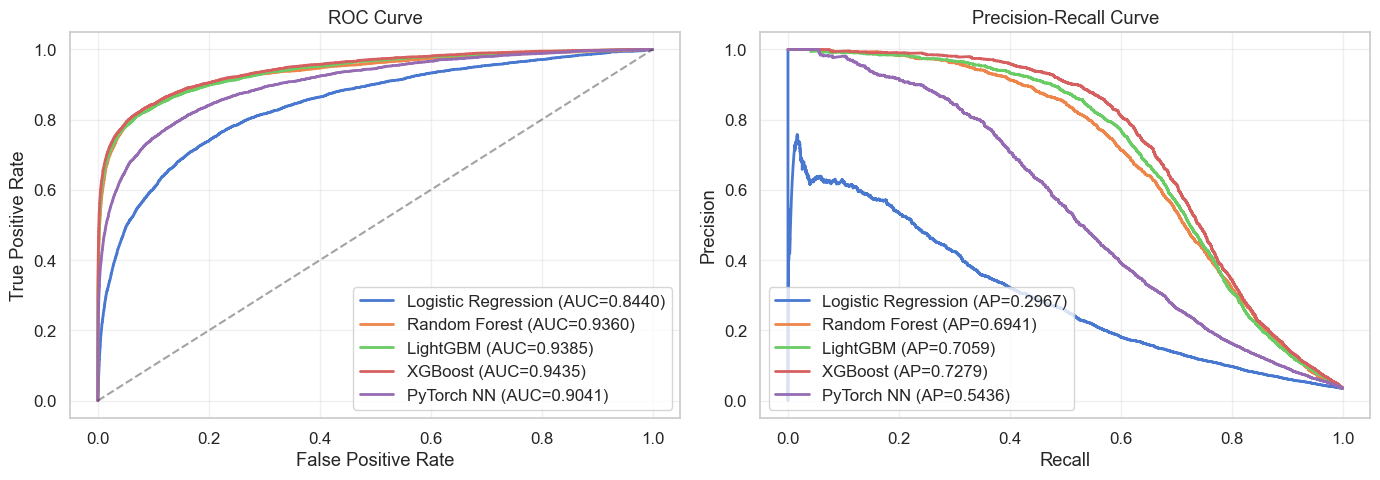

Melhor modelo: XGBoost


In [ ]:
# Add NN to results
y_prob_dict['PyTorch NN'] = nn_prob

# Compute metrics for the NN: ROC-AUC, PR-AUC, Brier, ECE, LogLoss and KS
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from ds_tools.evaluation.calibration import brier_score, expected_calibration_error
from scipy.stats import ks_2samp

auc_nn = roc_auc_score(y_val, nn_prob)
ap_nn = average_precision_score(y_val, nn_prob)
brier_nn = brier_score(y_val.values, nn_prob)
ece_nn = expected_calibration_error(y_val.values, nn_prob)
logloss_nn = log_loss(y_val, nn_prob)
try:
    ks_nn = ks_2samp(nn_prob[y_val==1], nn_prob[y_val==0]).statistic
except Exception:
    ks_nn = float('nan')

print(f'NN metrics — ROC-AUC: {auc_nn:.4f}, PR-AUC: {ap_nn:.4f}, LogLoss: {logloss_nn:.6f}, Brier: {brier_nn:.6f}, ECE: {ece_nn:.4f}, KS: {ks_nn:.4f}')

# Ensure KS column exists and insert the NN row using a dict to avoid mismatched columns
if 'KS' not in results_df.columns:
    results_df['KS'] = np.nan
row = {'ROC-AUC': auc_nn, 'PR-AUC': ap_nn, 'Brier': brier_nn, 'ECE': ece_nn, 'LogLoss': logloss_nn, 'KS': ks_nn}
for col in results_df.columns:
    results_df.loc['PyTorch NN', col] = row.get(col, np.nan)

# Display final comparison
display(results_df.sort_values('PR-AUC', ascending=False))

fig = plot_roc_pr(y_val.values, y_prob_dict)
plt.show()

# Choose the best model
best_name = results_df['PR-AUC'].idxmax()
if best_name == 'PyTorch NN':
    best_model = nn_model
    best_prob = nn_prob
else:
    best_model = models[best_name]
    best_prob = y_prob_dict[best_name]
print(f'Best model: {best_name}')

## 7 — Test Evaluation, Threshold Optimization, SHAP, and Serialization

Evaluate the best model on the test set, optimize the threshold, generate SHAP explanations (if applicable), and save artifacts for production.

In [ ]:
from ds_tools.visualization.plots import plot_shap_summary, plot_threshold_analysis
from ds_tools.evaluation import ClassificationEvaluator

# Previsão no teste
def predict_test(model, X):
    if isinstance(model, MLP):
        model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X.values, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')
            return model(X_tensor).cpu().numpy()
    else:
        return model.predict_proba(X)[:, 1]

y_test_prob = predict_test(best_model, X_test)

# Avaliação
metrics = ClassificationEvaluator(y_test.values, y_test_prob, model_name=best_name)
metrics.summary()
fig = metrics.plot_full_report(); plt.show()

# Threshold optimization
fig, best_threshold = plot_threshold_analysis(y_test.values, y_test_prob)
plt.show()
print(f'Optimal F1 threshold: {best_threshold:.2f}')

# SHAP (apenas para modelos tree-based)
if best_name in ['LightGBM', 'XGBoost', 'CatBoost', 'Random Forest']:
    shap_sample = X_test.sample(n=min(5000, len(X_test)), random_state=SEED)
    fig = plot_shap_summary(best_model, shap_sample, feature_names=X_test.columns, max_display=15)
    plt.show()

# Serialização
artefacts = {
    'model': best_model,
    'feature_cols': list(X.columns),
    'threshold': best_threshold,
    'model_name': best_name,
}
joblib.dump(artefacts, '../artefacts/fraud_model.joblib')
print('Artefatos salvos em ../artefacts/fraud_model.joblib')

In [ ]:
# Create submission.csv ready to submit to Kaggle (inline code)
from pathlib import Path

# locate test files (kagglehub if available)
try:
    data_dir = Path(kagglehub.competition_download('ieee-fraud-detection'))
except Exception:
    data_dir = Path('.') / 'data'  # adjust manually if needed

tx = pd.read_csv(data_dir / 'test_transaction.csv')
idp = pd.read_csv(data_dir / 'test_identity.csv')
test = tx.merge(idp, on='TransactionID', how='left')

feature_cols = artefacts.get('feature_cols', []) if 'artefacts' in globals() else []
if not feature_cols:
    raise RuntimeError('`feature_cols` not found in `artefacts`. Run the serialization cell first.')

# Prepare features — conservative attempt
X_sub = test.reindex(columns=feature_cols).copy()

# Fill numeric NaNs and simple handling for categoricals
num_cols = X_sub.select_dtypes(include=[np.number]).columns
X_sub[num_cols] = X_sub[num_cols].fillna(-999)
obj_cols = X_sub.select_dtypes(include=['object', 'category']).columns
for c in obj_cols:
    X_sub[c] = X_sub[c].fillna('missing')
    le_dict = artefacts.get('label_encoders', {}) if 'artefacts' in globals() else {}
    if c in le_dict:
        X_sub[c] = le_dict[c].transform(X_sub[c].astype(str))
    else:
        X_sub[c] = X_sub[c].astype('category').cat.codes

# Predict
if ('artefacts' in globals() and artefacts.get('model_name') == 'PyTorch NN') or ('best_model' in globals() and isinstance(best_model, MLP)):
    probs = predict_test(best_model, X_sub, scaler=artefacts.get('scaler') if 'artefacts' in globals() else None)
else:
    probs = best_model.predict_proba(X_sub)[:, 1]

submission = pd.DataFrame({'TransactionID': test['TransactionID'], 'isFraud': probs})
submission.to_csv('submission.csv', index=False)
print(f'Submission saved to submission.csv (rows: {len(submission)})')